In [50]:
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("dataset/preprocessed.csv")
df.shape

(762106, 44)

In [51]:
df = df.drop(df[df.target == -1].index)
df.shape

(762094, 44)

In [52]:
# Separate input features and target
y = df.target

In [53]:
X = df.drop('target', axis = 1)

In [54]:
# setting up testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)


### Train the model without re-sampling

In [55]:
# Train the model

rfc = RandomForestClassifier(n_estimators = 100, n_jobs = -1).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [66]:
# Performance results

print("Accuracy: \t", accuracy_score(y_test, rfc_pred))
print("F1 Score: \t", f1_score(y_test, rfc_pred, average = 'macro'))
print("Precision:\t", precision_score(y_test, rfc_pred, average = 'macro'))
print("Recall:   \t", recall_score(y_test, rfc_pred, average = 'macro'))

Accuracy: 	 0.5393073838466544
F1 Score: 	 0.49431185854810317
Precision:	 0.49554771601617575
Recall:   	 0.49684951164875046


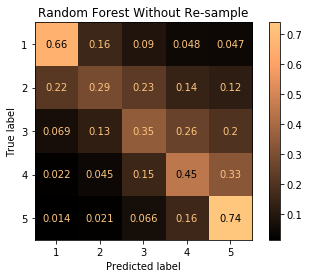

In [57]:
# Plot normalized confusion matrix

import matplotlib.pyplot as plt

classes = ["1", "2", "3", "4", "5"]
title = "Random Forest Without Re-sample"
disp = plot_confusion_matrix(rfc, X_test, y_test, display_labels = classes, cmap = "copper", normalize = "true")
disp.ax_.set_title(title)
plt.show()

### Train the model with re-sampling

In [58]:
# Re-sample the training set

sm = SMOTEENN(random_state = 27, n_jobs = -1)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [59]:
print(X_train.shape)

(426472, 43)


In [60]:
# Train the model

rfc_sampled = RandomForestClassifier(n_estimators = 100, n_jobs = -1).fit(X_train, y_train)
rfc_sampled_pred = rfc_sampled.predict(X_test)

In [65]:
# Performance results

print("Accuracy: \t", accuracy_score(y_test, rfc_sampled_pred))
print("F1 Score: \t", f1_score(y_test, rfc_sampled_pred, average = 'macro'))
print("Precision:\t", precision_score(y_test, rfc_sampled_pred, average = 'macro'))
print("Recall:   \t", recall_score(y_test, rfc_sampled_pred, average = 'macro'))

Accuracy: 	 0.5317807730259705
F1 Score: 	 0.49581962892703685
Precision:	 0.4859187899718974
Recall:   	 0.517050210422324


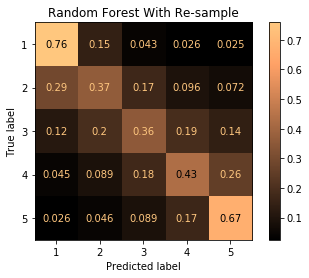

In [62]:
# Plot normalized confusion matrix

classes = ["1", "2", "3", "4", "5"]
title = "Random Forest With Re-sample"
disp = plot_confusion_matrix(rfc_sampled, X_test, y_test, display_labels = classes, cmap = "copper", normalize = "true")
disp.ax_.set_title(title)
plt.show()
